# Music Suggestion Using Feature Extraction and Euclidean Feature Space Distance


# Project Outline


Imports and Constants

Define feature functions and weights
  - call feature function on dictionary name

  - weight the dictionary value

Load and analyze songs to feature dictionary
  - import each song

  - call dictionary feature function
  
  Optional - Save and Load Feature Dictionary

Song comparison and plotting
  - import new song

  - grab other song features from dict

  - normalize feature values
  
  - get feature space distance from song dict
  
  - order distance dictionary

Return top n suggested songs

Graph feature space

Find best weighting
 - import val songs
 - call dictionary feature function
 
 Optional - Save and Load Feature Dictionary
 - iterate songs types with random weights to find best weights
 - slight randomization on existing weights to find better weights

# Imports and Constants

In [ ]:
!pip install essentia
!pip install librosa

import numpy as np
import matplotlib.pyplot as plt
import essentia.standard as es
from google.colab import drive
import glob
import math
import os
import pprint
import librosa

drive.mount('/content/drive')
Fs = 44100

np.set_printoptions(precision = 4, linewidth = 200)
pp = pprint.PrettyPrinter(indent = 4, width = -1, compact = False)

# Define Feature Functions and Weights

In [ ]:
def spectral_centroid(signal):
  return np.mean(librosa.feature.spectral_centroid(y=signal,sr=Fs))

def spectral_bandwidth(signal):
  return np.mean(librosa.feature.spectral_bandwidth(y=signal,sr=Fs))
  
def spectral_contrast(signal):
  return np.mean(librosa.feature.spectral_contrast(y=signal,sr=Fs))

def spectral_flatness(signal):
  return np.mean(librosa.feature.spectral_flatness(y=signal))

def spectral_rolloff(signal):
  return np.mean(librosa.feature.spectral_rolloff(y=signal,sr=Fs))

def zero_crossing_rate(signal):
  return np.mean(librosa.feature.zero_crossing_rate(y=signal))

def beats_per_minute(signal):
  return librosa.beat.tempo(signal, sr=Fs)[0]

def mel_frequency_cepstral_coefficients(signal):
  return np.mean(librosa.feature.mfcc(y=signal, sr=Fs))

def chroma_energy_normalized(signal):
  return np.mean(librosa.feature.chroma_cens(y=signal, sr=Fs))

features = {
  'Beats per Minute' : {
    'function': beats_per_minute,
    'weight' : 0.10073099170764999
  },
  # 'Chroma Energy Normalized' : {
  #   'function': mel_frequency_cepstral_coefficients,
  #   'weight' : 0.37457892259655745
  # },
  'Mel-Frequency Cepstral Coefficients' : {
    'function': mel_frequency_cepstral_coefficients,
    'weight' : 0.35019682961705667
  },
  # 'Spectral Bandwidth' : {
  #   'function': spectral_bandwidth,
  #   'weight': 0.03643391362869297
  # },
  'Spectral Centroid': {
      'function': spectral_centroid,
      'weight': 0.32056689959174445
  },
  # 'Spectral Contrast' : {
  #   'function': spectral_contrast,
  #   'weight': 0.0599498276346494
  # },
  'Spectral Flatness' : {
    'function': spectral_flatness,
    'weight': 0.9655571511187548
  }
  # 'Spectral Rolloff' : {
  #   'function': spectral_rolloff,
  #   'weight' : 0.9750647486633035
  # },
  # 'Zero Crossing Rate' : {
  #   'function': zero_crossing_rate,
  #   'weight' : 0.826535510909782
  # }
}

def extract_features(audioSig):
  return {feature_name: feature_params['function'] (audioSig) for feature_name, feature_params in features.items()}

# Load and Analyze Songs to Feature Dictionary



In [ ]:
#song_folders = glob.glob('/content/drive/Shared drives/ECE160-Visell-2022/Media Files/minimusicspeech/*/')
song_folders = glob.glob('/content/drive/MyDrive/GTZAN/genres_original_split/train/*/')

print ("Loading Songs, Aquiring Features: ")

# collect song information into dictionary
songs = []
for folder in song_folders:
  if "/speech" in folder:
    continue
  found_songs = glob.glob(folder + "*.wav")
  print (f"Folder: {folder}\tSongs Found: {str(len(found_songs))}")
  for song in found_songs:
    songs.append({
        'name': song.rsplit(os.sep,2)[-1][:-4],
        'type' : folder.rsplit(os.sep,2)[1],
        'features' : extract_features(es.MonoLoader(filename=song, sampleRate=Fs)())
    })
    pp.pprint(songs[-1])

#Save And Load Feature Dictionary From File

## Save Dictionary

In [ ]:
import pickle

pickle.dump(songs, open("/content/drive/MyDrive/song_dictionary_small.p", "wb"))

## Load Dictionary


Dictionary is stored here, download and drag into session storage:  

https://drive.google.com/file/d/1---hoBnVGlPG7ncTk-yU-wetMPwlSRmA/view?usp=sharing

In [ ]:
import pickle

songs = pickle.load(open("/content/drive/MyDrive/song_dictionary_small.p", "rb"))
pp.pprint(songs)

# Song Comparison and Plotting

Suggested Songs for classical.00068:

classical.00097	type: classical	distance: 0.04574803107748986
classical.00007	type: classical	distance: 0.07545658533889255
jazz.00000	type: jazz	distance: 0.07590159611704073
classical.00059	type: classical	distance: 0.07668300973185518
classical.00000	type: classical	distance: 0.08837282082965366
blues.00006	type: blues	distance: 0.09203683649827703
classical.00006	type: classical	distance: 0.09818542246189184

Please note - for the following graphs values are not normalized as this is performed in the distancing function


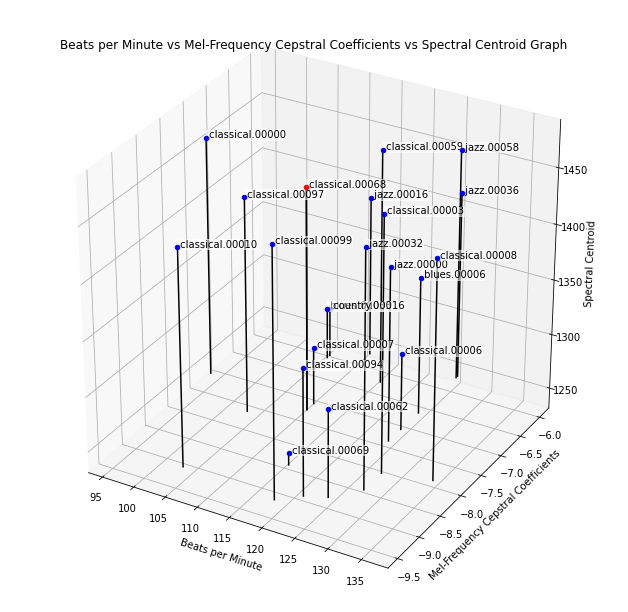

In [ ]:
# for calculating mean and std dev
feature_normals = {}
for song in songs:
  for feature, value in song['features'].items():
    feature_normals.setdefault(feature, []).append(value)

for feature, array in feature_normals.items():
  feature_normals[feature] = {
      'mean': np.mean(array),
      'std' : np.std(array)
  }

def get_distance(vector1, vector2):
  return math.sqrt(sum((pos1 - pos2) ** 2.0 for pos1, pos2 in zip(vector1, vector2)))

def normalize_feature_value(value, name):
  return (value - feature_normals[name]['mean']) / feature_normals[name]['std']

def weight_feature_value(value, name):
  return value * features[name]['weight']
                  
def weighted_normalized_feature_array(feature_dict):
  return np.array([weight_feature_value(normalize_feature_value(value, name), name) for name, value in feature_dict.items()])

def feature_space_graph(feature_array, song_distances, new_song, song_name, num_songs_graphed):
  fig = plt.figure(figsize=(11, 11))
  ax = plt.axes(projection ='3d')
  ax.set_title(' vs '.join(feature_array.tolist()) + " Graph")
  ax.set_xlabel(feature_array[0])
  ax.set_ylabel(feature_array[1])
  ax.set_zlabel(feature_array[2]) 
  
  positions = []
  positions.append([new_song[feature_array[0]], new_song[feature_array[1]], new_song[feature_array[2]]])
  ax.scatter(*positions[-1], label=song_name, color='r')
  ax.text(*positions[-1], s=" "+song_name, size=10, bbox=dict(facecolor='w', alpha=0.5, pad=0, linewidth=None, edgecolor='w'))

  for (distance, song), i in zip(sorted(song_distances.items()), range(num_songs_graphed)):
    positions.append([song['features'][feature_array[0]], song['features'][feature_array[1]], song['features'][feature_array[2]]])
    #ax.scatter(*positions[-1], label=song['name'], color=np.random.rand(3,))
    ax.scatter(*positions[-1], label=song['name'], color='b')
    ax.text(*positions[-1], s=" "+song['name'], size=10, bbox=dict(facecolor='w', alpha=0.5, pad=0, linewidth=None, edgecolor='w'))
  
  # draw stem lines
  z_min, z_max = ax.get_zlim()
  ax.plot(np.array([new_song[feature_array[0]],new_song[feature_array[0]]]),np.array([new_song[feature_array[1]],new_song[feature_array[1]]]), np.array([z_min,new_song[feature_array[2]]]), color="k")

  for position in positions:
    ax.plot(np.array([position[0],position[0]]),np.array([position[1],position[1]]),np.array([z_min,position[2]]), color="k")

  #plt.legend()
  plt.show()

def MusicRecommender(queryfilename, Nrecommendations):
  audio_file = es.MonoLoader(filename=queryfilename, sampleRate=Fs)()
  song_name = queryfilename.rsplit(os.sep,2)[-1][:-4]
  global features
  new_song = {feature_name: feature_params['function'] (audio_file) for feature_name, feature_params in features.items()}
  
  # get a weighted normalized feature array vector for new song
  new_song_feature_vector = weighted_normalized_feature_array(new_song)

  song_distances = {}
  for song in songs:
    # get a weighted normalized feature array vector for existing song
    song_feature_vector = weighted_normalized_feature_array(song['features'])

    # calculate distance
    song_distances[get_distance(new_song_feature_vector, song_feature_vector)] = song

  print(f"Suggested Songs for {song_name}:\n\n" + '\n'.join([f'{song_distances[distance]["name"]}\ttype: {song_distances[distance]["type"]}\tdistance: {distance}' for distance, i in zip(sorted (song_distances.keys()), range(Nrecommendations))]))

  # show graphs of feature spaces
  feature_space = np.array(list(features.keys()))
  shape = int(math.floor(feature_space.shape[0]/3))

  print("\nPlease note - for the following graphs values are not normalized as this is performed in the distancing function")
  for feature_array in feature_space[:shape * 3].reshape(shape, 3):
    feature_space_graph(feature_array, song_distances, new_song, song_name, 20)
      
#MusicRecommender('/content/drive/Shared drives/ECE160-Visell-2022/Media Files/redhot_short.wav', 7)
MusicRecommender('/content/drive/MyDrive/GTZAN/genres_original_split/test/classical/classical.00068.wav', 7)

# Find Best Weighting

In [ ]:
# laod val songs to val_songs
val_folders = glob.glob('/content/drive/MyDrive/GTZAN/genres_original_split/val/*/')

val_songs = []

for folder in val_folders:
  found_songs = glob.glob(folder + "*.wav")
  print (f"Folder: {folder}\tSongs Found: {str(len(found_songs))}")
  for song in found_songs:
    #print(song)
    val_songs.append({
        'name': song.rsplit(os.sep,2)[-1][:-4],
        'type' : folder.rsplit(os.sep,2)[1],
        'features' : extract_features(es.MonoLoader(filename=song, sampleRate=Fs)())
    })
    pp.pprint(val_songs[-1])

##Save Val Dictionary

In [ ]:
import pickle

pickle.dump(val_songs, open("/content/drive/MyDrive/val_song_dictionary_small.p", "wb"))

##Load Val Dictionary

In [ ]:
import pickle

val_songs = pickle.load(open("/content/drive/MyDrive/val_song_dictionary_small.p", "rb"))
pp.pprint(val_songs)

##Random Search

In [ ]:
import random
import copy

random.seed()
# find good weights from random
def find_best_weight_random(numiterations):
  global features
  global songs
  global val_songs
  
  best_accuracy = 0
  best_feature = None
  for iteration in range(numiterations):
    print(f"Iteration {iteration} of {numiterations}")

    # randomize weights
    for feature in features.keys():
      features[feature]['weight'] = random.random()

    type_accuracies = {}
    for val_song in val_songs:

      # get a weighted normalized feature array vector for new song
      val_song_feature_vector = weighted_normalized_feature_array(val_song['features'])

      song_distances = {}
      # compare to each song
      for song in songs:
        # get a weighted normalized feature array vector for existing song
        song_feature_vector = weighted_normalized_feature_array(song['features'])

        # calculate distance
        song_distances[get_distance(val_song_feature_vector, song_feature_vector)] = song

      num_distances = len(song_distances)
      # get accuracy
      accuracy = 0
      for position, distance in enumerate(sorted(song_distances.keys())):
        if song_distances[distance]['type'] == val_song['type']:
          accuracy += ((num_distances - position) / num_distances) ** 3

      type_accuracies.setdefault(val_song['type'], []).append(accuracy)

    for type_key, type_array in type_accuracies.items():
      type_accuracies[type_key] = np.mean(type_array)

    accuracy = np.mean(list(type_accuracies.values()))
    if accuracy > best_accuracy:
      print(f"\nNew Highest Accuracy:  {accuracy}")
      pp.pprint(type_accuracies)
      pp.pprint(features)
      best_accuracy = accuracy
      best_feature = copy.deepcopy(features)
      
  if best_feature is not None:
    features = copy.deepcopy(best_feature)

  print(f"\n\nBest Feature Accuracy:  (Not Percentages)\n")
  pp.pprint(best_accuracy)
  print(f"Features for these Accuracies:")
  pp.pprint(features)

# find good weights from existing
def find_best_weight_iterative(numiterations):
  global features
  global songs
  global val_songs
  
  old_accuracy = 0
  old_feature = copy.deepcopy(features)
  for iteration in range(numiterations):
    print(f"Iteration {iteration} of {numiterations}")

    # randomize weights
    for feature in features.keys():
      if iteration > 0:
        features[feature]['weight'] += (random.random() - .5) / 90

    type_accuracies = {}
    for val_song in val_songs:

      # get a weighted normalized feature array vector for new song
      val_song_feature_vector = weighted_normalized_feature_array(val_song['features'])

      song_distances = {}
      # compare to each song
      for song in songs:
        # get a weighted normalized feature array vector for existing song
        song_feature_vector = weighted_normalized_feature_array(song['features'])

        # calculate distance
        song_distances[get_distance(val_song_feature_vector, song_feature_vector)] = song

      num_distances = len(song_distances)
      # get accuracy
      accuracy = 0
      for position, distance in enumerate(sorted(song_distances.keys())):
        if song_distances[distance]['type'] == val_song['type']:

          accuracy += ((num_distances - position) / num_distances) ** 3
      
      type_accuracies.setdefault(val_song['type'], []).append(accuracy)

    for type_key, type_array in type_accuracies.items():
      type_accuracies[type_key] = np.mean(type_array)

    accuracy = np.mean(list(type_accuracies.values()))
    if accuracy > old_accuracy:
      print(f"\nNew Highest Accuracy:  {accuracy}")
      pp.pprint(type_accuracies)
      pp.pprint(features)
      old_accuracy = accuracy
      old_feature = copy.deepcopy(features)
    else:
      features = copy.deepcopy(old_feature)
      

  print(f"\n\nBest Feature Accuracy:  (Not Percentages)\n")
  pp.pprint(old_accuracy)
  print(f"Features for these Accuracies:  ")
  pp.pprint(features)

#find_best_weight_random(4000)
find_best_weight_iterative(300)

# Discussion


*In your submission, explain your approach, describe and justify the choices you made, and describe alternatives you may have considered (and why you did not choose them).  Discuss the performance of your method by listening to examples.  Plot examples of the feature values of the query and returned (or not returned) results using the methods you applied in Mini Project 1.  Discuss your findings.*

---

  In order to best solve this problem, it was primarily important to clearly organize data for processing. Therefore, two main dictionaries were used to best organize features and songs.

  In the feature dictionary, the feature name, function, and weighting are dynamically defined. By defining features in a dynamic environment, weighting and functions are able to be changed quickly to find the best combinations.

  Initially, the librosa library was considered to find where the features or beats occurred in the song, where the physical locations would then be compared. However, this would introduce inaccuracy, as comparing songs based on where features occur rather than the intensity that they occur could weigh songs that coincidentally have similar location higher over actually similar features over the larger song. 

  The comparison function is also dynamically and intuitively defined. In order to find similar songs, each song feature value is normalized and weighed appropriately to the parameters. Then, the features are combined together into a single vector for each song, and a n-feature space euclidean distance is calculated between the original songs and the new song. This n-feature vector can calculate any number of defined features, and weighs each distance exactly as the parameters are set. Simple two dimensional euclidean distance over multiple sets were not chosen, as getting the distance over the entire feature set would introduce error when acquiring the mean after.

  After researching into music recognition and similarity, there were two noteworthy papers:

"Calculating Musical Rhythm Similarity" by Battenberg  
http://ericbattenberg.com/pdf/rhythm_similarity07.pdf

"Musical Similarity Analysis based on Chroma Features and
Text Retrieval Methods" by Englmeier et al.
https://btw-2015.informatik.uni-hamburg.de/res/proceedings/Workshops/Stud/Englmaier-Musical_Similarity_Analys.pdf

  In Battenberg's paper, there was great success in using Mel-Frequency Cepstral Coefficients alone to find musical similarity using a similarity matrix. This feature is well known for having commonality to the way humans hear audio. As such, this feature was initially implemented along with a very significant weight value.

  In Englmeier et al., there was usage of a combination of chroma feature extraction and text extraction for their 'Music Information Retrieval Application', which was designed to match music of different artists. As there is very little music with lyrics in the dataset, the chroma feature extraction strategy was solely implemented. However, after testing, it was found that this chroma feature extraction was not beneficial, so it was removed.

  The prodecure for choosing additional features for extraction was reading through documentation on the functionality, and concluding if they could help with finding similar songs. Many features give a variety of structure data for the many song patterns that exist. However, too any features made results less accurate, so the following features were chosen: BPM for song speed, Mel-Frequency Cepstral Coefficients as this was shown as performant in Battenberg, Spectral Centroid as this was used in the first assignment to good effect, and Spectral Flatness, as this song helps identify noisy signals such as rock and metal.

  As there were now multiple features, it was unclear how they could possibly reliably be weighed. To solve this problem, two functions were developed to automatically find good weights.

  The primary function developed randomly picks weights from 0 to 1 for each feature and checks distances for all validation songs of each genre, and ranks accuracy based on how high the same genre songs are in the distance list in the GTZAN dataset. It calculates the mean accuracy rating for each song distance and gets the mean of these values for overall score. This gives a good sense of performance over all song types, and it iteratively searches to find the best score. This function finds a good local maxima of weights for all song genres.

  The secondary funtion developed iteratively randomizes small deltas on top of the best randomly picked weights, and optimizes to find the top of the local maxima. The accuracy gain is small but can be significant if the local maxima found by the primary function was at the bottom of the curve.

  After running these functions for many iterations, a high weighting was found for Spectral Flatness and middle weightings for Spectral Centroid and Mel-Frequency Cepstral Coefficients. As these functions measure accuracy given genre ratings, weightings may have diverged from the most similar sounding songs. However, based on the scale of testing, it would be impossible to have a human listen to all combinations and give a similarity score.

  As a result of automatic weighting, there is a very high correlation of genre type suggestions, especially in classical, metal, and pop genres. It is not always that the genre represents the music style well, but this algorithm returns similar songs cross genre. In general, the results give a palpable similarity of sound in the 'energy' and 'feel' from the suggested related songs.  The results are very satisfying.

